# ece278a final presenatation
by Abby Bertics

## Outline
1. Images as graphs
2. Problem set-up
4. Applying digital image processing algorithms...

## 1. Images as graphs

Recall...
#### Definition:
An image is graph, $G=(V,E)$ where
* each node $v_i \in V$ is a pixel in the image and
* the (undirected) edges $e_{ij} \in E$ connect pairs of pixels
* the weights $w(e_{ij})$ often represent how similar the two pixels are (eg, by intensity or colour)
   

### Edges

Between:
* neighbors -- fast
* all pixels -- most information but excessive
* best: somewhere in between

### Weights

Define weight of edges by difference of brightness (or intensity, colour, texture, etc) values of pixels:
$$ w_{xy} = exp(\frac{-||F(x)-F(y)||^2}{\sigma_I^2}) $$

Equation from: [Shi and Malik 2000, IEEE](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=868688)
   

### Why?

This helps us with things like segmentation (ie, via norm cut alg)

<img src="images/graph-cut.png" width="400px">

## 2. Problem set up: Navigation

Navigation is an essential and ubiquitous cognitive capacity. But, little is known about the underlying representations and how they are acquired. 

**Research questions:**
* How do people navigate and represent maze-like environments?
    * eg, as sequences of landmarks, graphs, or spatial grids
* What differentiates "good" navigators from "bad" ones?
* What differentiates "easy" paths from "hard" ones?

### Maze task

* 100 adults (47f, 53m)
* Two phases: exploration and test



<img src="images/maze.png" width="800px">

### Example test path

<img src="images/test-example.gif" width="300px">



A little complicated. How do we represent? 

* Static: heat map, strings, 
* Dynamic: trajectories through time

### Graph representation of a path: flow tree

* Nodes = decision points where >=1 person makes a different decision than the group
* Edges = edges in maze
* Weights = how many people make that decision



### For a test path:

* A path is easier (or the group is better) if:
    * people make more uniform decisions getting from A to B.
* In tree language:
    * fewer nodes on the tree and/or,
    * tree is less deep


<img src="images/ex-reeb.png" width=700px>


<img src="images/end-ex.png" width="500px">

## 4. Applying digital image processing algorithms...

Both: involve analyzing spatial relationships and patterns

Relevant algorithms:
1. Segmentation
2. Edge-detection
    * Images: Edge detection finds where significant changes occur (boundaries). 
    * Reeb Graphs: Edges show where significant changes in decisions occur (transitions between paths).
3. Clustering and hierarchical analysis


### Imports & Load data

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.readwrite import json_graph
import os
import pandas as pd
import pydot

pd.options.mode.chained_assignment = None

In [6]:
# load data into dataframe
df = pd.read_csv("data/MLINDIV_train_full.csv")

test_df = df[df["eprocs"].str.contains("Test")]

test_df["subj_mean_acc"] = test_df.groupby("Subject")["accuracy"].transform("mean")
test_df["path_mean_acc"] = test_df.groupby(["StartAt", "EndAt"])["accuracy"].transform("mean")

test_df['quartile'] = (
    pd.qcut(test_df['subj_mean_acc'], 4, labels=[1, 2, 3, 4])
)

# test_df.head()

### Tree construction and plotting fns

In [2]:
def all_traj_same(trajs, which_trajs, max_traj_len):
    if len(set([len(trajs[t]) for t in which_trajs])) != 1: return False

    for i in range(max_traj_len):
        if len(set([trajs[t][i] for t in which_trajs])) != 1: return False
    return True
        
def make_reeb_graph_recursive(start_i, start_node, trajs, which_trajs, G, visited, SUCCESS="", DEBUG=False):
    if DEBUG: print(f"DO REEB, {start_i}, {start_node}, {which_trajs}")
    times_before = visited.get(start_node, 0) 
    visited[start_node] = times_before
    to_add = start_node + "_" + str(times_before)

    max_traj_len = max([len(trajs[t]) for t in which_trajs])

    ## BASE CASE 1: SINGLETON ##
    ## BASE CASE 2: ALL THE SAME ##
    if len(which_trajs) == 1 or all_traj_same(trajs, which_trajs, max_traj_len):
        end_node = trajs[which_trajs[0]][-1]
        times_before = visited.get(end_node, -1) + 1
        visited[end_node] = times_before
        
        end_node +=  "_" + str(times_before)
        if DEBUG: print(f"BASE CASE: {which_trajs}, last: {end_node}")

        color = "green" if SUCCESS in end_node else "yellow"
        G.add_node(end_node, color=color, end=True)
        G.add_edge(to_add, end_node, weight=len(which_trajs))

        return
    

    ## RECURSIVE STEP ##
    if DEBUG: print(f"FOR LOOP, {start_i}, {which_trajs}")
    for step in range(start_i, max_traj_len):
        
        new_gn = {}
        for i in which_trajs:
            traj = trajs[i]

            ## STOPPING CONDITION FOR THIS ONE GUY ##
            if step >= len(traj): 
                new_gn["DONE"] = new_gn.get("DONE", []).copy() + [i]
            else:
                new_node = traj[step]     
                new_gn[new_node] = new_gn.get(new_node, []).copy() + [i]

        if DEBUG: print("NEW_GN", new_gn)
        # decide whether we need a reeb node
        
        # people went different ways!!
        if len(new_gn.keys()) > 1:
            times_before = visited.get(start_node, 0)
            sn = start_node + "_" + str(times_before)
            
            # the thing happened at the node before this! all the paths in this fn are at the same point there so it doesnt mattter
            old_one = trajs[which_trajs[0]][step-1]
            times_before = visited.get(old_one, -1) + 1
            visited[old_one] = times_before
            
            on = old_one + "_" + str(times_before)
            G.add_node(on, color="blue", end=False)
            if DEBUG: print(f"ADDING NEW BLUE NODE {on}")
            
            G.add_edge(sn, on, weight=len(which_trajs))
            if DEBUG: print(f"ADDING NEW EDGE from {sn} to {on}, weight is {len(which_trajs)}")

            
            for k, v in new_gn.items():
                if DEBUG: print("RECURSE")
                if DEBUG and k == "DONE":
                    print("*@#)$*$#()*(#@($")
                    print(new_gn)
                make_reeb_graph_recursive(step+1, old_one, trajs,  v, G, visited, SUCCESS=SUCCESS)

            return

def collapse_traj(traj):
    '''
    Remove turns so that A A B B G G G becomes A B G.
    '''
    new_traj = [traj[0]]
    for t in traj:
        if t != new_traj[-1]:
            new_traj.append(t)
    return new_traj
    
def do_reeb_for_start_end(df, start_node, end_node, Q, use_turns=True):
    this_df = df[(df["StartAt"] == start_node) & (df["EndAt"] == end_node) & (df["quartile"]  == Q)]
    
    trajs = []
    count = 0
    for _, row in this_df.iterrows():
        path = row["e_paths"] if use_turns else row["paths"]
        if path[-2:] == "NA": path = path[:-2] # this happens if the test ends unsuccessfully
        
        states = path.split()
        if not use_turns: states = collapse_traj(states)
        trajs.append(states)
        count += 1
        # if count == 15: break

    visited = {}

    G = nx.Graph()
    G.add_node(start_node + "_0", color="red", end=False)

    # print(start_node)
    # for t in trajs:
    #     print(t)
    make_reeb_graph_recursive(0, start_node, trajs, [i for i in range(len(trajs))], G, visited, SUCCESS=end_node[0], DEBUG=False)
    return G

In [3]:
def plot_reeb(G, n_colors=None, title=""):
    fig, this_ax = plt.subplots(1, 1, figsize=(10,5))
      
    pos = graphviz_layout(G, prog="dot")
    
    edges = G.edges()
    # colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] * .4 for u,v in edges]

    nodes = G.nodes()
    # print(edges, "\n",nodes,"\n", pos)
        # for n in nodes:
        #     print(n, G.nodes[n])
    n_labels = {n: n[:-2] for n in G}
    if not n_colors:
        n_colors = [G.nodes[n].get("color", "blue") for n in nodes]
        # print(n_colors)
        # print ((q-1) // 2, (q-1) % 2)
    nx.draw_networkx_nodes(G, pos, node_color=n_colors, node_size=500, alpha=0.7, ax=this_ax)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, ax=this_ax)
    nx.draw_networkx_labels(G, pos, labels=n_labels, font_size=14, font_weight="bold", ax=this_ax)

        
    this_ax.axis("off")
    # this_ax.set_title(f"Q{q}", fontsize=30)
    
    plt.title(title)
    plt.show()

### Make the trees to analyse

['L_0', 'G_0', 'G_1', 'H_0', 'Q_0', 'T_0', 'Y_0', 'W_0', 'T_1', 'J_0', 'N_0', 'B_0', 'H_1', 'D_0', 'K_0', 'E_0', 'F_0', 'N_1', 'M_0', 'U_0', 'T_2', 'U_1', 'J_1']
[('L_0', 'G_0'), ('G_0', 'G_1'), ('G_1', 'H_0'), ('G_1', 'B_0'), ('G_1', 'H_1'), ('H_0', 'Q_0'), ('H_0', 'N_0'), ('Q_0', 'T_0'), ('Q_0', 'J_0'), ('T_0', 'Y_0'), ('T_0', 'W_0'), ('T_0', 'T_1'), ('H_1', 'D_0'), ('H_1', 'T_2'), ('D_0', 'K_0'), ('D_0', 'E_0'), ('E_0', 'F_0'), ('E_0', 'U_0'), ('F_0', 'N_1'), ('F_0', 'M_0'), ('T_2', 'U_1'), ('T_2', 'J_1')]


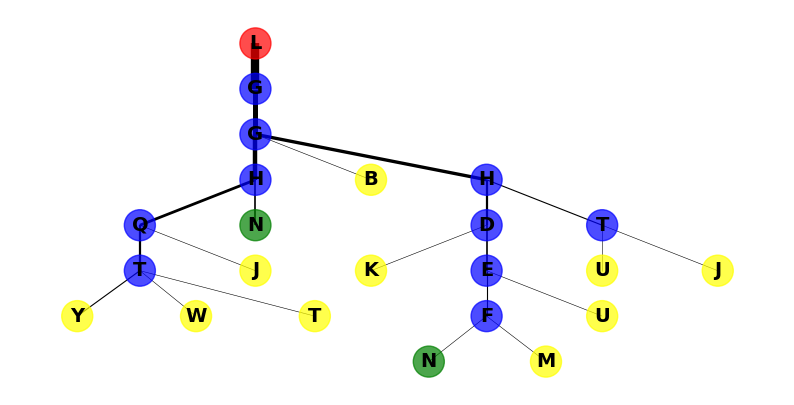

In [8]:
G = do_reeb_for_start_end(test_df, "L", "N", 1, use_turns=False)

print(G.nodes)
print(G.edges)
plot_reeb(G)

Gs = [do_reeb_for_start_end(test_df, "L", "N", i, use_turns=False) for i in range(1,5)]

### 1. **Segmentation**
In image processing, segmentation divides an image into meaningful parts. You can use graph-based segmentation algorithms to divide the Reeb graph into meaningful clusters of decision paths.

**Graph Application**: Use algorithms like spectral clustering or community detection to segment the Reeb graph into clusters representing different navigation strategies.

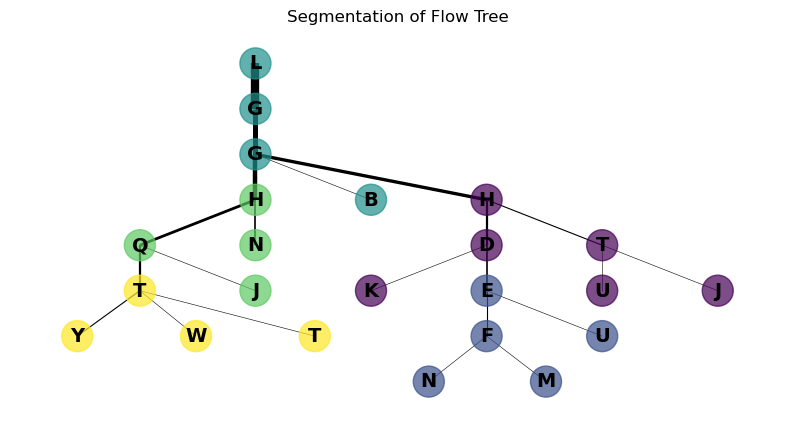

In [19]:
# Community detection (segmentation)             
communities = nx.algorithms.community.greedy_modularity_communities(G)

node_dict = {}
for i, n in enumerate(G.nodes):
    node_dict[n] = i

colors = [0] * len(G.nodes)
for i, comm in enumerate(communities):
    for node in comm:
        colors[node_dict[node]] = i

plot_reeb(G, n_colors=colors, title="Segmentation of Flow Tree")


In [15]:
def add_source_sink(graph, source='source', sink='sink'):
    # Add the source and sink nodes
    graph.add_node(source)
    graph.add_node(sink)
    
    # Add edges from the source node to all other nodes
    for node in graph.nodes():
        if "L" in node:
            graph.add_edge(source, node, weight=1)
        if "N" in node:
            graph.add_edge(node, sink, weight=1)
    
    return graph

You run into the same min-cut issues here (ie, only one node selected)
1 ({'source'}, {'F_0', 'sink', 'H_0', 'M_0', 'N_1', 'J_0', 'E_0', 'T_0', 'Y_0', 'U_0', 'G_0', 'N_0', 'J_1', 'W_0', 'T_2', 'K_0', 'L_0', 'B_0', 'Q_0', 'T_1', 'H_1', 'U_1', 'G_1', 'D_0'})


In [21]:
flow_G = add_source_sink(G.copy())

m_cut, m_part = nx.minimum_cut(flow_G, _s="source", _t="sink", capacity="weight")

print("You run into the same min-cut issues here (ie, only one node selected)")
print(m_part)

You run into the same min-cut issues here (ie, only one node selected)
({'source'}, {'F_0', 'sink', 'H_0', 'M_0', 'N_1', 'J_0', 'E_0', 'T_0', 'Y_0', 'U_0', 'G_0', 'N_0', 'J_1', 'W_0', 'T_2', 'K_0', 'L_0', 'B_0', 'Q_0', 'T_1', 'H_1', 'U_1', 'G_1', 'D_0'})


In [22]:
import numpy as np
from scipy.sparse.linalg import eigsh
import skimage.graph as skgraph
from sklearn.cluster import KMeans

def normalized_cut(graph):
    # Step 1: Compute the Degree Matrix
    degree_matrix = np.diag([graph.degree(node) for node in graph.nodes()])
    
    # Step 2: Compute the Adjacency Matrix
    adjacency_matrix = nx.to_numpy_array(graph) 
    
    # Step 3: Compute the Laplacian Matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    # Step 4: Compute the Normalized Laplacian
    with np.errstate(divide='ignore'):
        d_sqrt_inv = np.diag(1.0 / np.sqrt(np.diag(degree_matrix)))
    normalized_laplacian = d_sqrt_inv @ laplacian_matrix @ d_sqrt_inv
    
    # Step 5: Solve the Generalized Eigenvalue Problem
    eigvals, eigvecs = eigsh(normalized_laplacian, which='SM', k=2)

    # Step 6: Use K-means clustering on the second smallest eigenvector to partition the graph
    fiedler_vector = eigvecs[:, 1].reshape(-1, 1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(fiedler_vector)
    labels = kmeans.labels_
    
    
    # Convert boolean partition array to node sets
    part1 = {node for idx, node in enumerate(graph.nodes()) if labels[idx] == 0}
    part2 = set(graph.nodes()) - part1
    
    return part1, part2

Partition 1: {'H_0', 'D_0', 'K_0', 'L_0', 'E_0', 'T_0', 'B_0', 'Q_0', 'Y_0', 'T_1', 'U_0', 'G_0', 'N_0', 'H_1', 'W_0', 'G_1', 'J_0'}
Partition 2: {'F_0', 'M_0', 'N_1', 'U_1', 'J_1', 'T_2'}


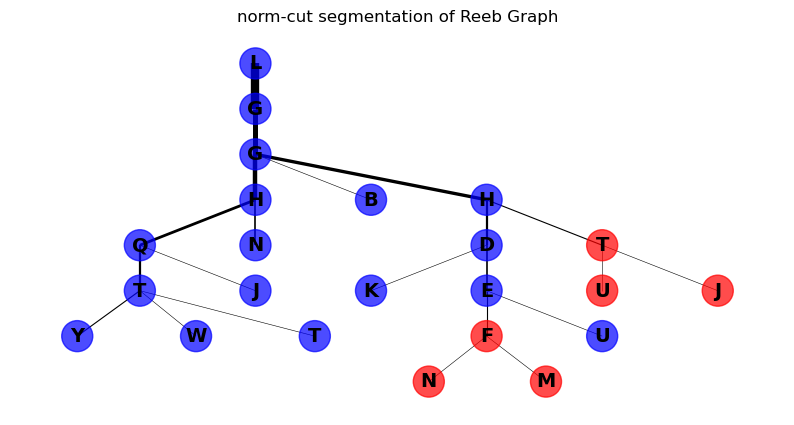

In [28]:
part1, part2 = normalized_cut(flow_G)

flow_G.remove_edges_from(nx.selfloop_edges(flow_G))
flow_G.remove_nodes_from(["source", "sink"])

colors = []
for n in flow_G.nodes:
    colors.append("blue" if n in part1 else "red")

print("Partition 1:", part1)
print("Partition 2:", part2)
plot_reeb(flow_G, n_colors=colors, title="norm-cut segmentation of Reeb Graph")


### 2. **Edge Detection**
In image processing, edge detection identifies significant transitions in an image. For Reeb graphs, you can identify significant decision points and transitions using graph-based edge detection.

**Graph Application**: Highlight or analyze key transitions between major decision points using centrality measures or cut-based methods.

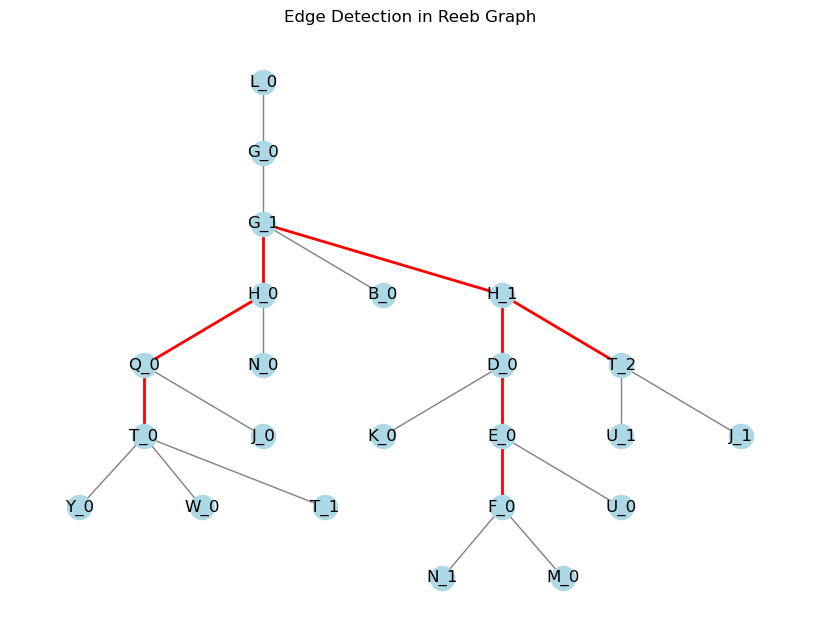

In [29]:
# Calculate edge betweenness centrality to identify important edges
edge_betweenness = nx.edge_betweenness_centrality(G)
important_edges = [edge for edge, centrality in edge_betweenness.items() if centrality > 0.2]

# Visualization
plt.figure(figsize=(8, 6))
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=important_edges, edge_color='red', width=2)
plt.title('Edge Detection in Reeb Graph')
plt.show()

### 3. **Clustering**
Image clustering groups similar pixels or segments. You can apply clustering algorithms to understand decision patterns at various levels:
* nodes
* paths
* people
* strategies

**Step 1: Extract Features** 

In [31]:
def extract_tree_features(graph, root):
    # Number of Nodes
    num_nodes = graph.number_of_nodes()
    
    # Number of Edges
    num_edges = graph.number_of_edges()
    
    # Tree Depth (Height)
    def tree_depth(graph, root):
        depths = nx.single_source_shortest_path_length(graph, root)
        return max(depths.values())
    
    depth = tree_depth(graph, root)
    
    # Average Node Degree
    avg_degree = np.mean([degree for node, degree in graph.degree()])
    
    # Diameter
    diameter = nx.diameter(graph)
    
    # Number of Leaves
    num_leaves = sum(1 for node in graph.nodes() if graph.degree(node) == 1)
    
    # Average Path Length
    avg_path_length = nx.average_shortest_path_length(graph)
    
    # Branching Factor
    branching_factors = [len(list(graph.neighbors(node))) for node in graph.nodes()]
    avg_branching_factor = np.mean(branching_factors)
    
    # Clustering Coefficient
    clustering_coeffs = nx.clustering(graph)
    avg_clustering_coeff = np.mean(list(clustering_coeffs.values()))
    
    # Put all features in a list
    features = [
        num_nodes,
        num_edges,
        depth,
        avg_degree,
        diameter,
        num_leaves,
        avg_path_length,
        avg_branching_factor,
        avg_clustering_coeff
    ]
    
    return features

In [32]:
# get all test paths by quartile
graphs = {}
for start_node, end_node in test_df.groupby(["StartAt", "EndAt"]).groups.keys():
    for i in range(1,5):
        graphs[(start_node, end_node, i)] = do_reeb_for_start_end(test_df, start_node, end_node, i, use_turns=False)

# extract features for each graph
features = np.array([extract_tree_features(graphs[g], g[0]+"_0") for g in graphs])
# get quartiles for each path
qs = [graph[2] for graph in graphs]

**Step 2: Cluster**

In [38]:
# Specify the number of clusters
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(features)

# Get the cluster assignments
labels = kmeans.labels_

**Step 3: Evaluate clusters**

In [39]:
import random
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

## CALCULATE ACCURACY OF CLUSTERING!!!

true_labels = [q-1 for q in qs]
baseline = [random.randint(0, 4) for _ in range(len(true_labels))]

print(f"ARI: {adjusted_rand_score(true_labels, labels):.2f} (random would be: {adjusted_rand_score(baseline, labels):.2f})")
print(f"NMI: {normalized_mutual_info_score(true_labels, labels):.2f} (random would be: {normalized_mutual_info_score(baseline, labels):.2f})")

ARI: 0.39 (random would be: -0.01)
NMI: 0.46 (random would be: 0.01)


**Step 4: Visualise Clusters**

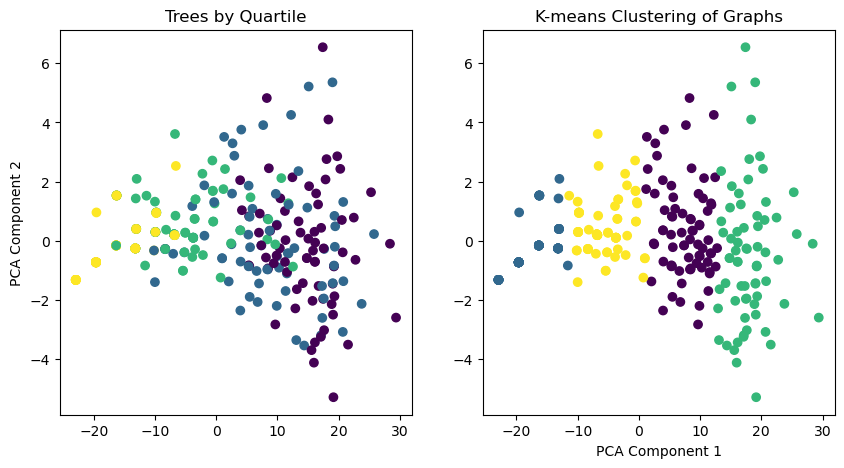

In [40]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
fix, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=qs)#, cmap='viridis')
axs[0].set_title('Trees by Quartile')
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels)#, cmap='viridis')
axs[1].set_title('K-means Clustering of Graphs')
plt.xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')
plt.show()


### Conclusion
* Images and graphs are two ways of representing structure and relationships.

# EXPLORATION OVERMATTER

### For exploration:

<img src="images/explore-ex.gif" width="200px">

A little complicated and long. 
* How do we represent? 
    * Static: heat map, strings, 
    * Dynamic: trajectories through time
* Can we use this graph to predict test performance?



### Flow trees for exploration:
<img src="images/q1-exp-ex.png" height="200px">  <img src="images/q4-exp-ex.png" height="200px">
<img src="images/a-q2-exp-ex.png" height="200px">  <img src="images/a-q4-exp-ex.png" height="200px">

In [118]:
### EXPLORE CLUSTERING
def do_reeb_for_explore_node(path, salient_node):
    
    trajs = []
    if path[-2:] == "NA": path = path[:-2] # this happens if the test ends unsuccessfully
    
    states = path.split()
    if not use_turns: states = collapse_traj(states)
    for i, s in enumerate(states): 
        if salient_node in s:
            trajs.append(states[i: i+10])

    G = nx.Graph()
    G.add_node(salient_node + "_0", color="red", end=False)
    
    if len(trajs) == 0: return G, 0

    # for t in trajs:
    #     print(t)
    visited = {}
    make_reeb_graph_recursive(0, salient_node, trajs, [i for i in range(len(trajs))], G, visited, SUCCESS="IMPOSSIBLE")
    return G, len(trajs)

explore_df = df[~df["eprocs"].str.contains("Test")]

# salient_node = "A"
# person = explore_df["Subject"].unique()[0]
use_turns = False
path_str = "e_paths" if use_turns else "paths"

# path = explore_df[explore_df["Subject"]==person][path_str].iloc[0]
# G, num_trajs = do_reeb_for_explore_node(path, salient_node)

explore_graphs = {}
for j, salient_node in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ"):

    count = 0
    for subj in explore_df["Subject"].unique():
        qs = test_df[test_df["Subject"] == subj]["quartile"]
        if len(qs) > 0:
            q = qs.iloc[0]
            
            for i, person_info in df[df["Subject"]==subj].iterrows():
        
                path = person_info[path_str]
                G, num_trajs = do_reeb_for_explore_node(path, salient_node)
                explore_graphs[(subj, i, q, salient_node)] = G

        count += 1
        if count == 10: break

print(explore_graphs)

# for start_node, end_node in test_df.groupby(["StartAt", "EndAt"]).groups.keys():
#     for i in range(1,5):
#         graphs[(start_node, end_node, i)] = do_reeb_for_start_end(test_df, start_node, end_node, i, use_turns=False)

# Extract features for each graph
# features = np.array([extract_graph_features(graphs[graph]) for graph in graphs])
exp_features = np.array([extract_tree_features(explore_graphs[g], g[3]+"_0") for g in explore_graphs])
exp_qs = [g[2] for g in explore_graphs]
exp_nodes = [g[3] for g in explore_graphs]

node_dgs = {'A': 1, 'B': 2, 'C': 3, 'D': 3, 'E': 3, 'F': 2, 'G': 3, 'H': 3, 'I': 1, 'J': 3, 'K': 1, 'L': 1, 'M': 3, 'N': 1, 'O': 1, 'P': 1, 'Q': 3, 'R': 4, 'S': 2, 'T': 3, 'U': 3, 'V': 2, 'W': 1, 'X': 3, 'Y': 1, 'Z': 2}
print({x: 2 for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"})

{(2, 0, 3, 'A'): <networkx.classes.graph.Graph object at 0x175cf31d0>, (2, 1, 3, 'A'): <networkx.classes.graph.Graph object at 0x175c670d0>, (2, 2, 3, 'A'): <networkx.classes.graph.Graph object at 0x174f2f4d0>, (2, 3, 3, 'A'): <networkx.classes.graph.Graph object at 0x177fac210>, (2, 4, 3, 'A'): <networkx.classes.graph.Graph object at 0x1763586d0>, (2, 5, 3, 'A'): <networkx.classes.graph.Graph object at 0x1792b3650>, (2, 6, 3, 'A'): <networkx.classes.graph.Graph object at 0x17585cc50>, (2, 7, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ea2010>, (2, 8, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ea26d0>, (2, 9, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ea3090>, (2, 10, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ea3210>, (2, 11, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ea39d0>, (2, 12, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ee8a50>, (2, 13, 3, 'A'): <networkx.classes.graph.Graph object at 0x178ee8f90>, (2, 14, 3, 'A')

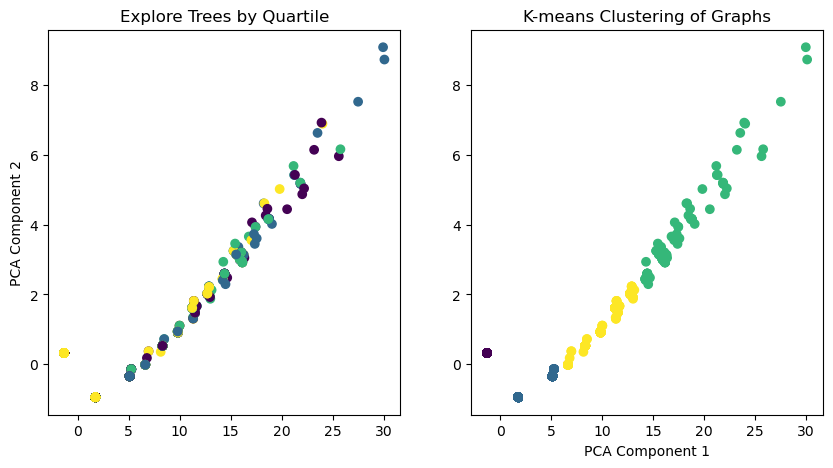

In [117]:
# Specify the number of clusters
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(exp_features)

# Get the cluster assignments
exp_labels = kmeans.labels_

# print("Cluster assignments:", exp_labels)

pca = PCA(n_components=2)
exp_reduced_features = pca.fit_transform(exp_features)

# Plot the clusters
fix, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(exp_reduced_features[:, 0], exp_reduced_features[:, 1], c=exp_qs)#, cmap='viridis')
axs[0].set_title('Explore Trees by Quartile')
axs[1].scatter(exp_reduced_features[:, 0], exp_reduced_features[:, 1], c=exp_labels)#, cmap='viridis')
axs[1].set_title('K-means Clustering of Graphs')
plt.xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')
plt.show()

# OTHER OVERMATTER

### 3. **Fourier Transform and Frequency Analysis**
In image processing, Fourier transforms decompose images into frequency components. For graphs, you can use spectral graph theory to analyze the frequency of different structural features.

**Graph Application**: Apply spectral analysis to identify the eigenvalues of the graph Laplacian, which can reveal structural properties of the Reeb graph.

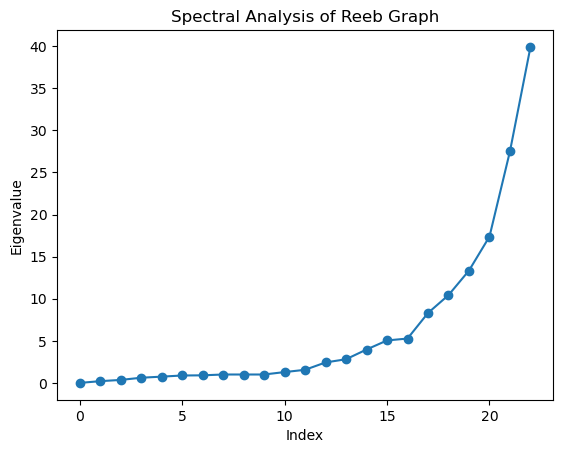

In [30]:
import numpy as np
from scipy.sparse import csgraph

# Calculate Laplacian matrix
laplacian = nx.laplacian_matrix(G).todense()

# Perform eigenvalue decomposition (Fourier analysis)
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

# Plot the eigenvalues (spectrum)
plt.plot(eigenvalues, 'o-')
plt.title('Spectral Analysis of Reeb Graph')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

### 3. **Pyramids and Multi-Scale Analysis**
In image processing, pyramids represent images at multiple resolutions. For graphs, you can create hierarchical representations to analyze decision-making at different levels of granularity.

**Graph Application**: Use hierarchical clustering or multi-scale graph analysis to understand decision patterns at various levels.

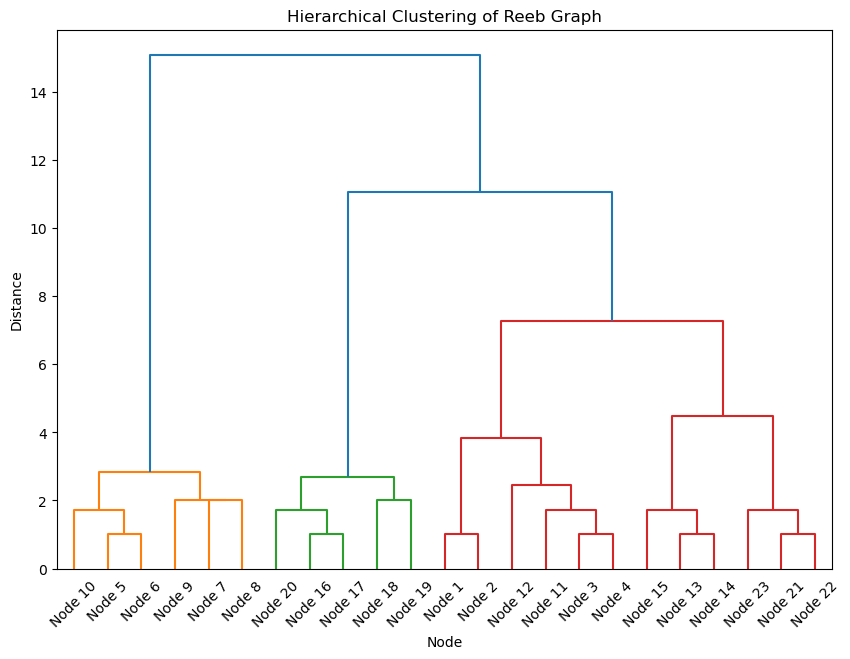

In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def condensed_distance_matrix(graph):
    # Compute the pairwise shortest path distances
    path_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    
    # Get the nodes in a fixed order
    nodes = list(graph.nodes())
    n = len(nodes)
    
    # Initialize the distance matrix
    distance_matrix = np.zeros((n, n))
    
    # Fill the distance matrix with path lengths
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = path_lengths[u][v]
            else:
                distance_matrix[i, j] = 0  # Distance to self is zero
    
    # Convert to condensed distance matrix using scipy's squareform
    condensed_distance_matrix = squareform(distance_matrix, checks=False)
    
    return condensed_distance_matrix


# Generate hierarchical clustering (multi-scale analysis)
Z = linkage(condensed_distance_matrix(G), method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f'Node {i}' for i in range(1, len(G.nodes) + 1)])
plt.title('Hierarchical Clustering of Reeb Graph')
plt.xlabel('Node')
plt.ylabel('Distance')
plt.show()